In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from jax import random, numpy as jnp
from stadion.models import LinearSDE, MLPSDE
from pprint import pprint
from stadion import kds_loss
import numpy as onp
import ot

2025-03-05 14:56:53.074061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741204613.084643 1415374 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741204613.087878 1415374 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from nn import NNSDE
from nonlinear_script import *

In [3]:
n = 1000
d = 2
r = 2
n_envs = 10
n_test_envs = 10
epsilon = 0.2
gamma = 0.98
activation = "mixed"
model_activation = "sigmoid"

model_hidden_size = 16

bandwidth = [1.0, 3.0, 5.0, 7.0]
steps = 50000
estimator = "linear"
reg = 0.000

scale = 1e-2
intv_scale = 0.3

n_samples_burnin=200
learning_rate = 0.003
weight_decay = 0.0001

seed = 12

In [4]:
key = random.PRNGKey(seed)

true_model = build_model(r, activation, epsilon, gamma, n_samples_burnin)
key, true_model, param = initialize_model(key, true_model, d)

# param["mlp_0"] = jax.numpy.eye(d, r)
# param["mlp_1"] = jax.numpy.eye(r, d)
# true_model.param = param

key, intv_param, datasets, targets = build_data(key, true_model, d, n_envs, intv_scale, n)
key, test_intv_param, test_datasets, test_targets = build_data(key, true_model, d, n_test_envs, intv_scale, n)


model = build_model(model_hidden_size, model_activation, epsilon, gamma, n_samples_burnin)
key, model = fit_model(key, model, datasets, targets, intv_param, bandwidth, steps, estimator,
                       reg, learning_rate, weight_decay, scale)

W0000 00:00:1741204624.891788 1415374 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


step:  5000 kds:     0.181323  | min remain:  1.7  sec/step: 0.002
step: 10000 kds:     0.022192  | min remain:  1.2  sec/step: 0.002
step: 15000 kds:     0.014132  | min remain:  1.0  sec/step: 0.002
step: 20000 kds:     0.012546  | min remain:  0.9  sec/step: 0.002
step: 25000 kds:     0.008733  | min remain:  0.7  sec/step: 0.002
step: 30000 kds:     0.016011  | min remain:  0.6  sec/step: 0.002
step: 35000 kds:     0.008466  | min remain:  0.4  sec/step: 0.002
step: 40000 kds:     0.010077  | min remain:  0.3  sec/step: 0.002
step: 45000 kds:     0.011839  | min remain:  0.1  sec/step: 0.002
step: 50000 kds:     0.017331  | min remain:  0.0  sec/step: 0.002


In [5]:
wds, mean, std = assess_model_mean(key, model, n_test_envs, test_intv_param, test_datasets, n)
print(wds)
print(mean, std)

[12.073437   62.618465    9.298383    2.3804526  66.77431     1.5824836
  0.78238124  0.32338315  1.3733411   3.454829  ]
16.066147 24.60408


In [6]:
wds, mean, std = assess_model_mean(key, true_model, n_test_envs, test_intv_param, test_datasets, n)
print(wds)
print(mean, std)

[0.29925087 0.18398297 0.23717627 0.08209263 0.20574674 0.04062687
 0.17812322 0.02222644 0.17221107 0.02799044]
0.14494275 0.09107846


In [7]:
# #W2
# wds, mean, std = assess_model(key, model, n_test_envs, test_intv_param, test_datasets, n, ot_epsilon = 0.2)
# print(wds)
# print(mean, std)

# wds, mean, std = assess_model(key, true_model, n_test_envs, test_intv_param, test_datasets, n, ot_epsilon = 0.2)
# print(wds)
# print(mean, std)

In [8]:
#s:4.1698165 6.20976
#s2:
#l:1.2479943 1.7765819
#l2:
#t:0.16724442 0.076956645
#t2:

In [9]:
#s:0.71756214 0.36002582
#s2:
#l:
#l2:
#t:0.14494275 0.09107846
#t2:

In [10]:
#s:
#s2:
#l:
#l2:
#t:
#t2:

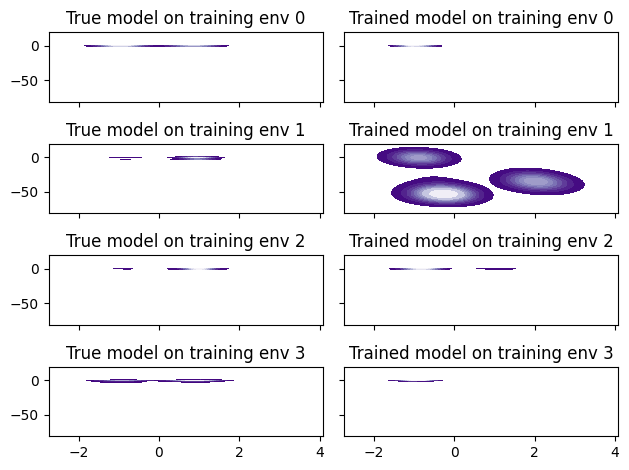

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

if d == 2:

    total = 4

    pred_datasets = []
    for k in range(total):
        local_intv_param = intv_param.index_at(k)
        key, subk = random.split(key)
        data = model.sample(subk, n_samples = n, intv_param = local_intv_param)
        pred_datasets.append(data)

    fig, axes = plt.subplots(nrows=total,ncols=2,sharex=True, sharey=True)

    
    for k in range(total):
    
        x = datasets[k][:,0]
        y = datasets[k][:,1]
        sns.kdeplot(x=x, y=y, ax = axes[k,0], fill=True,cmap="Purples_r")
        axes[k,0].set_title(f"True model on training env {k}")
        
        x = pred_datasets[k][:,0]
        y = pred_datasets[k][:,1]
        sns.kdeplot(x=x, y=y, ax = axes[k,1], fill=True,cmap="Purples_r")
        axes[k,1].set_title(f"Trained model on training env {k}")

    plt.tight_layout()
    plt.show()


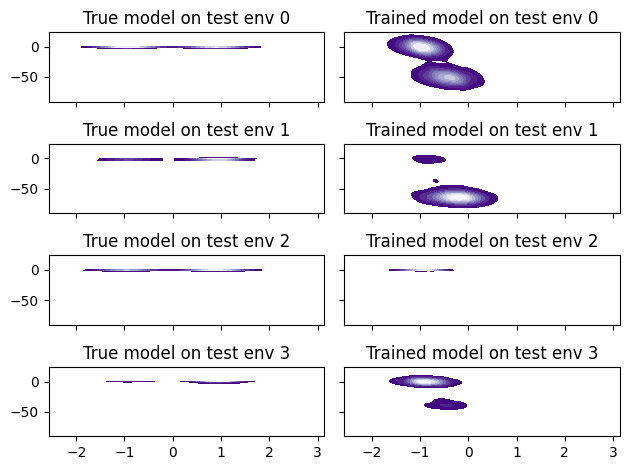

In [12]:
if d == 2:

    total = 4

    pred_test_datasets = []
    for k in range(total):
        local_intv_param = test_intv_param.index_at(k)
        key, subk = random.split(key)
        data = model.sample(subk, n_samples = n, intv_param = local_intv_param)
        pred_test_datasets.append(data)

    fig, axes = plt.subplots(nrows=total,ncols=2,sharex=True, sharey=True)

    for k in range(total):
    
        x = test_datasets[k][:,0]
        y = test_datasets[k][:,1]
        sns.kdeplot(x=x, y=y, ax = axes[k,0], fill=True,cmap="Purples_r")
        axes[k,0].set_title(f"True model on test env {k}")
        
        x = pred_test_datasets[k][:,0]
        y = pred_test_datasets[k][:,1]
        sns.kdeplot(x=x, y=y, ax = axes[k,1], fill=True,cmap="Purples_r")
        axes[k,1].set_title(f"Trained model on test env {k}")

    plt.tight_layout()
    plt.show()

In [13]:
print(model.param)

ModelParameters
{'A': Array([[ 7.07411170e-02,  6.85129762e-02,  7.21962154e-02,
         6.32064119e-02,  7.23585784e-02,  7.42367804e-02,
         7.00109154e-02,  7.20026568e-02,  7.04423636e-02,
         6.99942037e-02,  6.71439543e-02,  6.94109201e-02,
         7.31668547e-02,  7.16063753e-02,  6.78327829e-02,
         6.73174262e-02,  7.00688064e-02,  6.32536188e-02,
         6.98898286e-02,  7.35644698e-02],
       [ 5.96392043e-02,  5.95720373e-02,  4.00848500e-02,
         5.97965792e-02,  4.02069576e-02,  5.74791804e-02,
         6.00578301e-02,  2.87274979e-02,  3.42698172e-02,
         3.66567262e-02,  4.90910485e-02,  4.25197333e-02,
         5.06815054e-02,  3.61149088e-02,  5.26017100e-02,
         5.60643189e-02,  3.47830355e-02,  6.00516871e-02,
         5.51758744e-02,  5.93703501e-02],
       [-6.03120089e-01,  3.90368700e-01,  4.20791566e-01,
        -4.60490972e-01, -2.59777099e-01, -3.35957795e-01,
        -2.08971485e-01,  3.44683826e-01,  4.20071423e-01,
       

In [14]:
print(true_model.param)

ModelParameters
{'log_reversion': Array([ 0., -0.], dtype=float32),
 'mlp_0': Array([[1., 0.],
       [0., 1.]], dtype=float32),
 'mlp_1': Array([[1., 0.],
       [0., 1.]], dtype=float32),
 'mlp_b_0': Array([0., 0.], dtype=float32)}
